**Loading in packages**

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, recall_score
from sklearn.model_selection import GridSearchCV

**Load in datasets**


In [ ]:
# Load the data
df_customers = pd.read_csv("../data/customers.csv")
df_churn = pd.read_csv("../data/churn.csv")
df_transactions = pd.read_csv("../data/transactions_summary.csv")

# Common key 'customer_id' to merge the DataFrames
df = pd.merge(df_customers, df_churn, on='customer_id')

df_customers_clustered = pd.read_csv("../data/customers_with_clusters.csv")
df = df.merge(df_customers_clustered[['customer_id', 'Cluster']], on='customer_id', how='left')
df = df.dropna(subset=['Cluster'])

In [32]:
# Remove any negative age entries
df = df[df['age'] >= 0]
# Remove entries where the person is married or divorced and age is less than 21
df = df[~((df['marital'].isin(['married', 'divorced'])) & (df['age'] < 21))]
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
customer_id              0
age                      0
job                      0
marital                  0
education                0
credit_default           0
customer_segment         0
region                   0
income                   0
created_at               0
credit_card              0
personal_loan            0
mortgage                 0
savings_account          0
investment_product       0
auto_loan                0
wealth_management        0
churn_id                 0
churn_status             0
churn_date            9472
dtype: int64


In [33]:
# Add a column to indicate if the account is not active (last transaction more than 6 months old)
df['account_active'] = df_transactions['days_since_last_transaction'].apply(lambda x: 0 if x > 180 else 1)

# Convert 'created_at' to datetime
df['created_at'] = pd.to_datetime(df['created_at'])

# Calculate tenure in years and round up
current_date = datetime.now()
df['tenure'] = (current_date - df['created_at']).apply(lambda x: np.ceil(x.days / 365)).astype(int)

# Convert binary columns from 'yes'/'no' to 1/0
binary_columns = df.columns[10:17]
print(binary_columns)
df[binary_columns] = df[binary_columns].map(lambda x: 1 if x == 'yes' else 0)
df['churn_status'] = df['churn_status'].apply(lambda x: 1 if x == 'Yes' else 0)
df['credit_default'] = df['credit_default'].apply(lambda x: 1 if x == 'Yes' else 0)

# Create a new column 'total_products_purchased' by summing the binary columns
df['total_products_purchased'] = df[binary_columns].sum(axis=1)

# Calculate product utilization rate by income and tenure
df['product_utilization_rate_by_income'] = df.apply(
        lambda row: 0 if row['income'] == 0 else row['total_products_purchased'] / row['income'], axis=1)
df['product_utilization_rate_by_tenure'] = df.apply(
        lambda row: 0 if row['tenure'] == 0 else row['total_products_purchased'] / row['tenure'], axis=1)


Index(['credit_card', 'personal_loan', 'mortgage', 'savings_account',
       'investment_product', 'auto_loan', 'wealth_management'],
      dtype='object')


In [ ]:
df_encoded = pd.get_dummies(df['Cluster'], prefix='Cluster')

# Concatenate the encoded columns with the original dataframe (optional)
df = pd.concat([df, df_encoded], axis=1)
df = df.drop('Cluster', axis=1)

df_cluster_columns = df_encoded.filter(like='Cluster')

print(df_cluster_columns)

In [36]:
# Print the number of customers by relevant
num_churned_customers = df['churn_status'].sum()
print("Number of churned customers:", num_churned_customers)
num_active_customers = df['account_active'].sum()
print("Number of active customers:", num_active_customers)

Number of churned customers: 378
Number of active customers: 9208


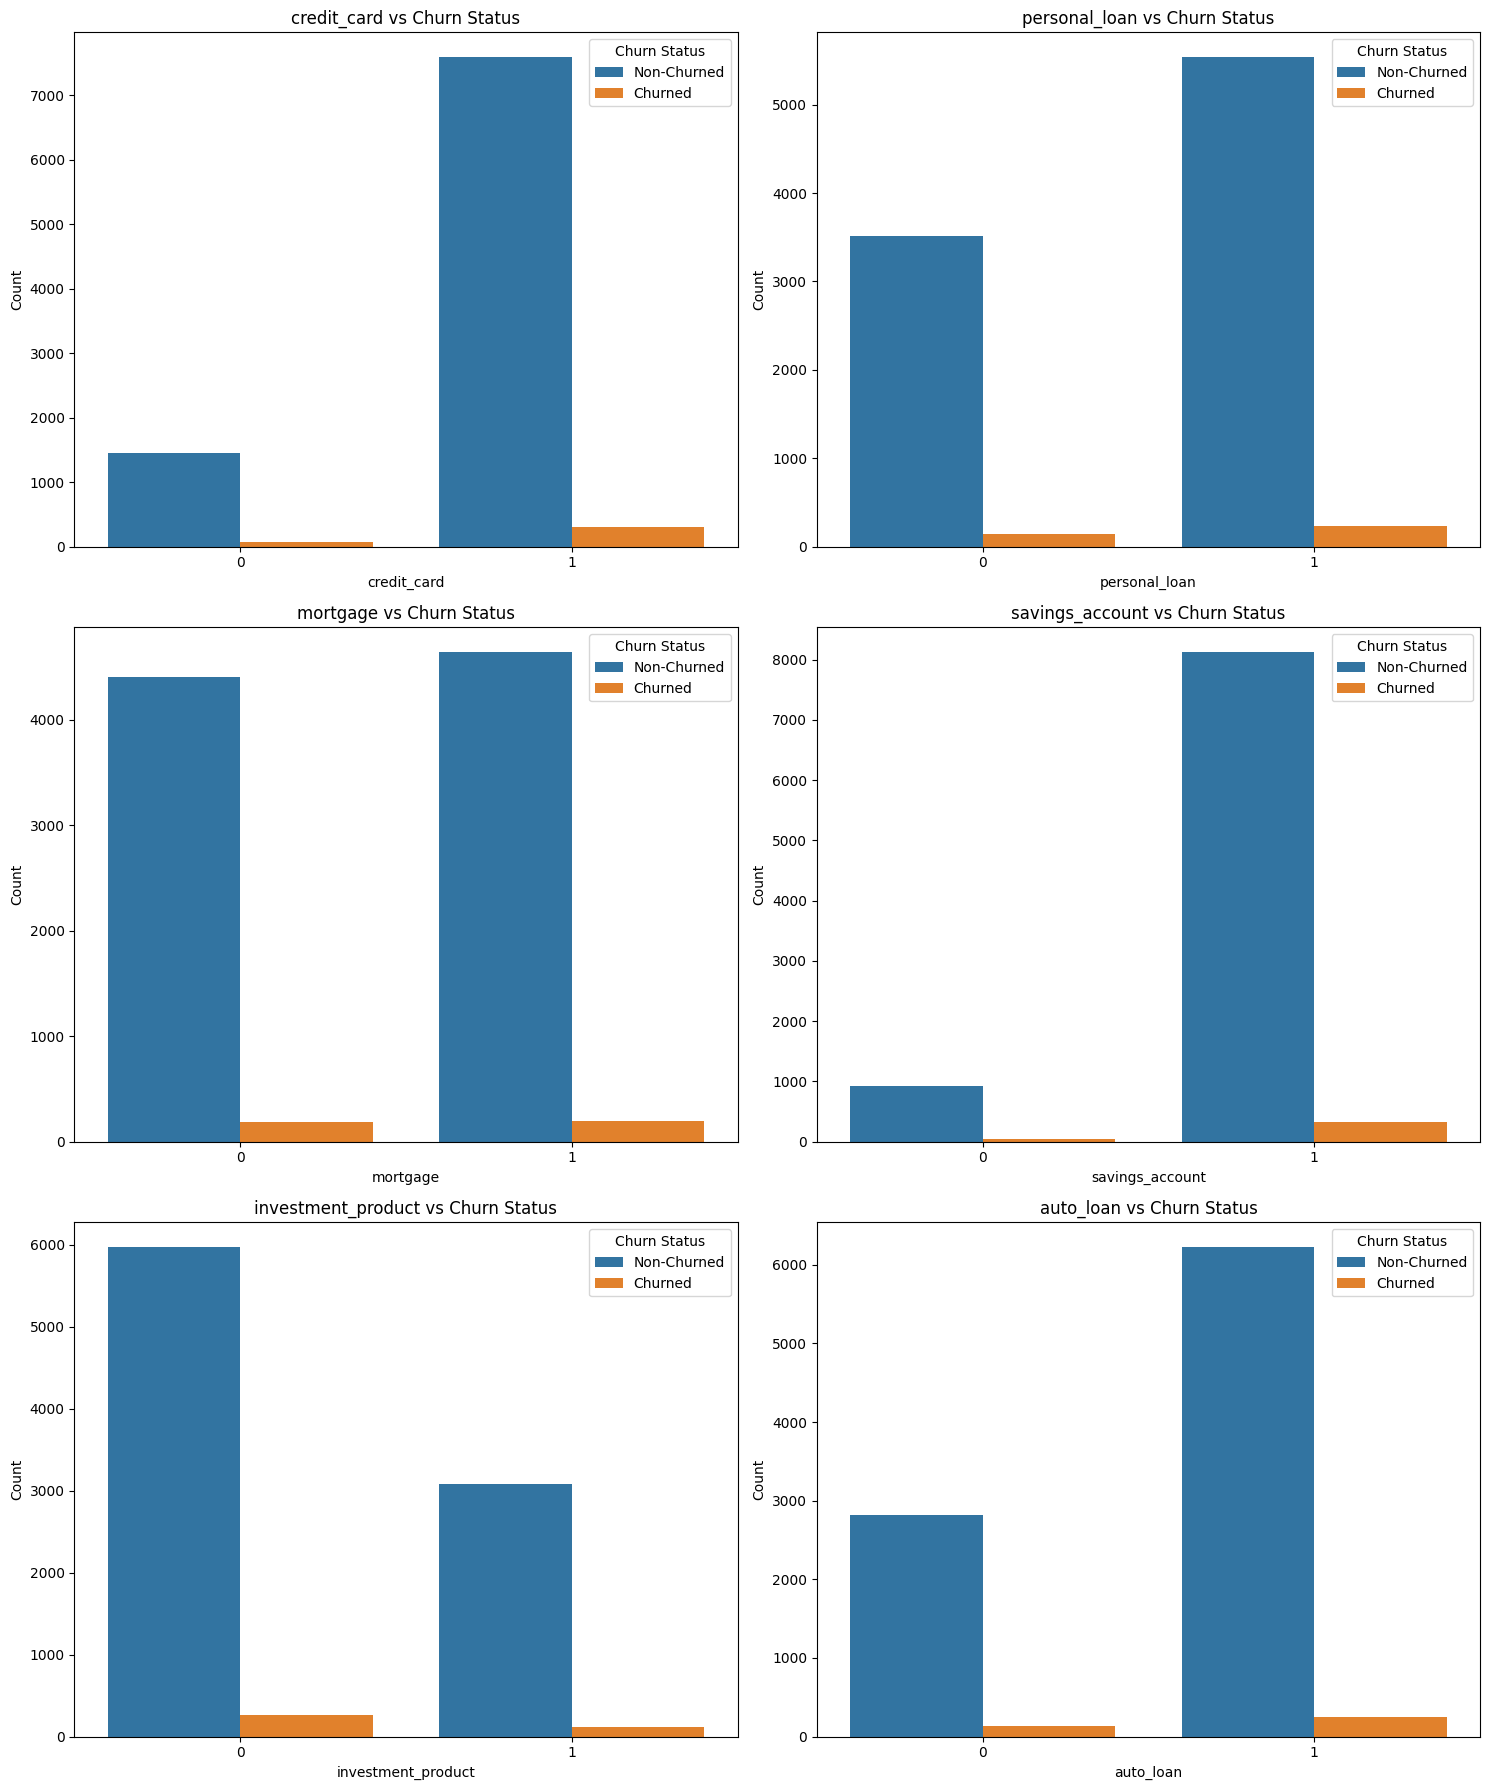

In [37]:
binary_columns = df.columns[10:16]
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

for i, column in enumerate(binary_columns):
    sns.countplot(x=column, hue='churn_status', data=df, ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f'{column} vs Churn Status')
    axes[i // 2, i % 2].set_xlabel(column)
    axes[i // 2, i % 2].set_ylabel('Count')
    axes[i // 2, i % 2].legend(title='Churn Status', labels=['Non-Churned', 'Churned'])

# Remove any empty subplots
for j in range(len(binary_columns), 6):
    fig.delaxes(axes[j // 2, j % 2])

plt.tight_layout()
plt.show()

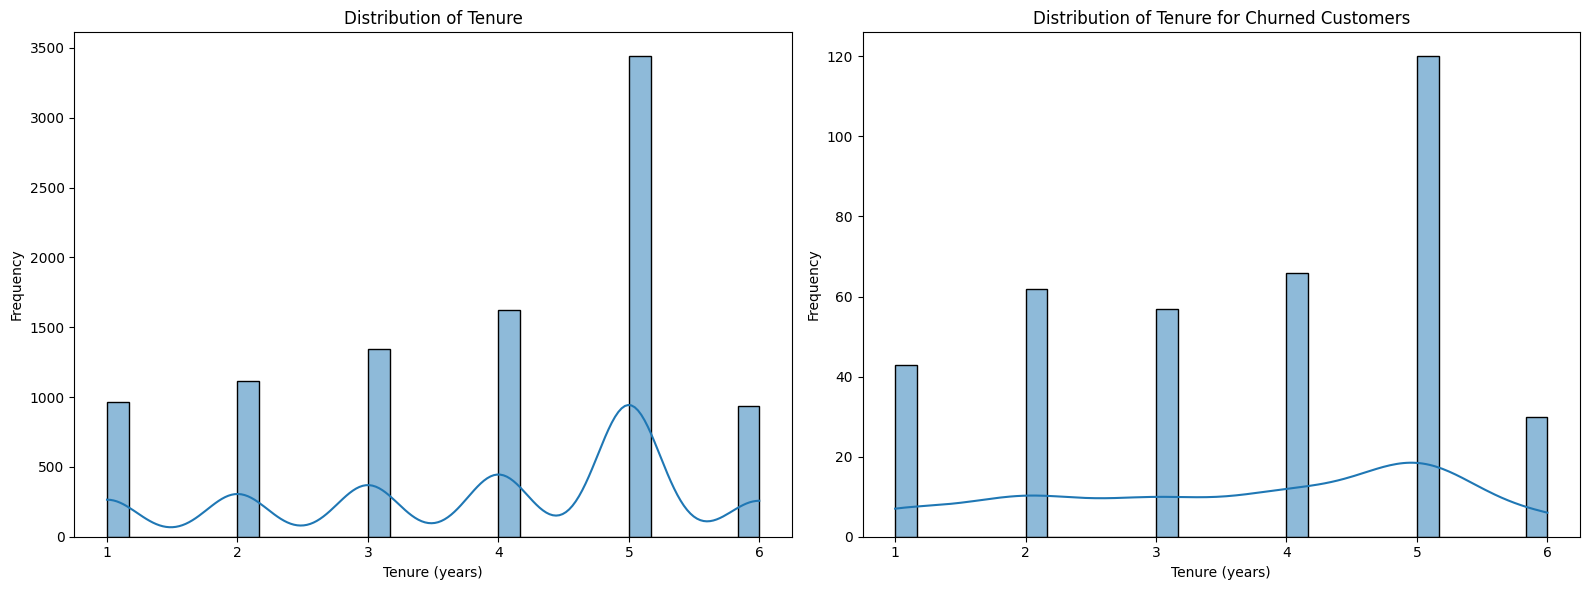

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot tenure
sns.histplot(df['tenure'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Tenure')
axes[0].set_xlabel('Tenure (years)')
axes[0].set_ylabel('Frequency')

# Plot tenure for churned customers
sns.histplot(df[df['churn_status'] == 1]['tenure'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Tenure for Churned Customers')
axes[1].set_xlabel('Tenure (years)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

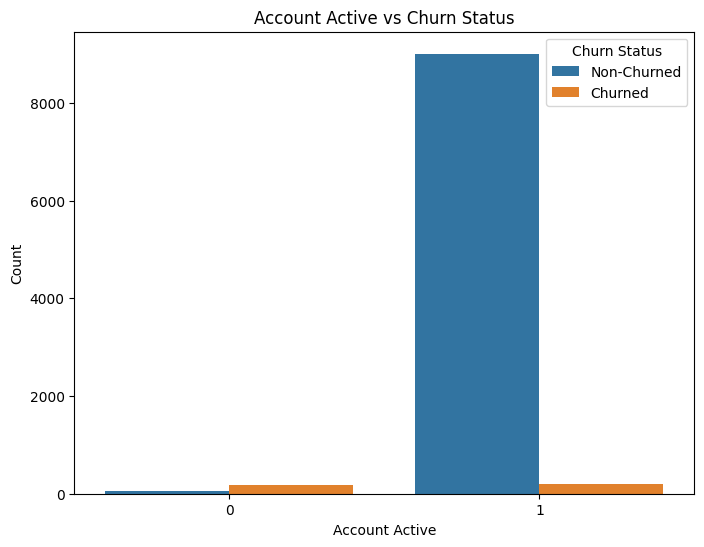

In [39]:
# Plot account_active against churn_status
plt.figure(figsize=(8, 6))
sns.countplot(x='account_active', hue='churn_status', data=df)
plt.title('Account Active vs Churn Status')
plt.xlabel('Account Active')
plt.ylabel('Count')
plt.legend(title='Churn Status', labels=['Non-Churned', 'Churned'])
plt.show()

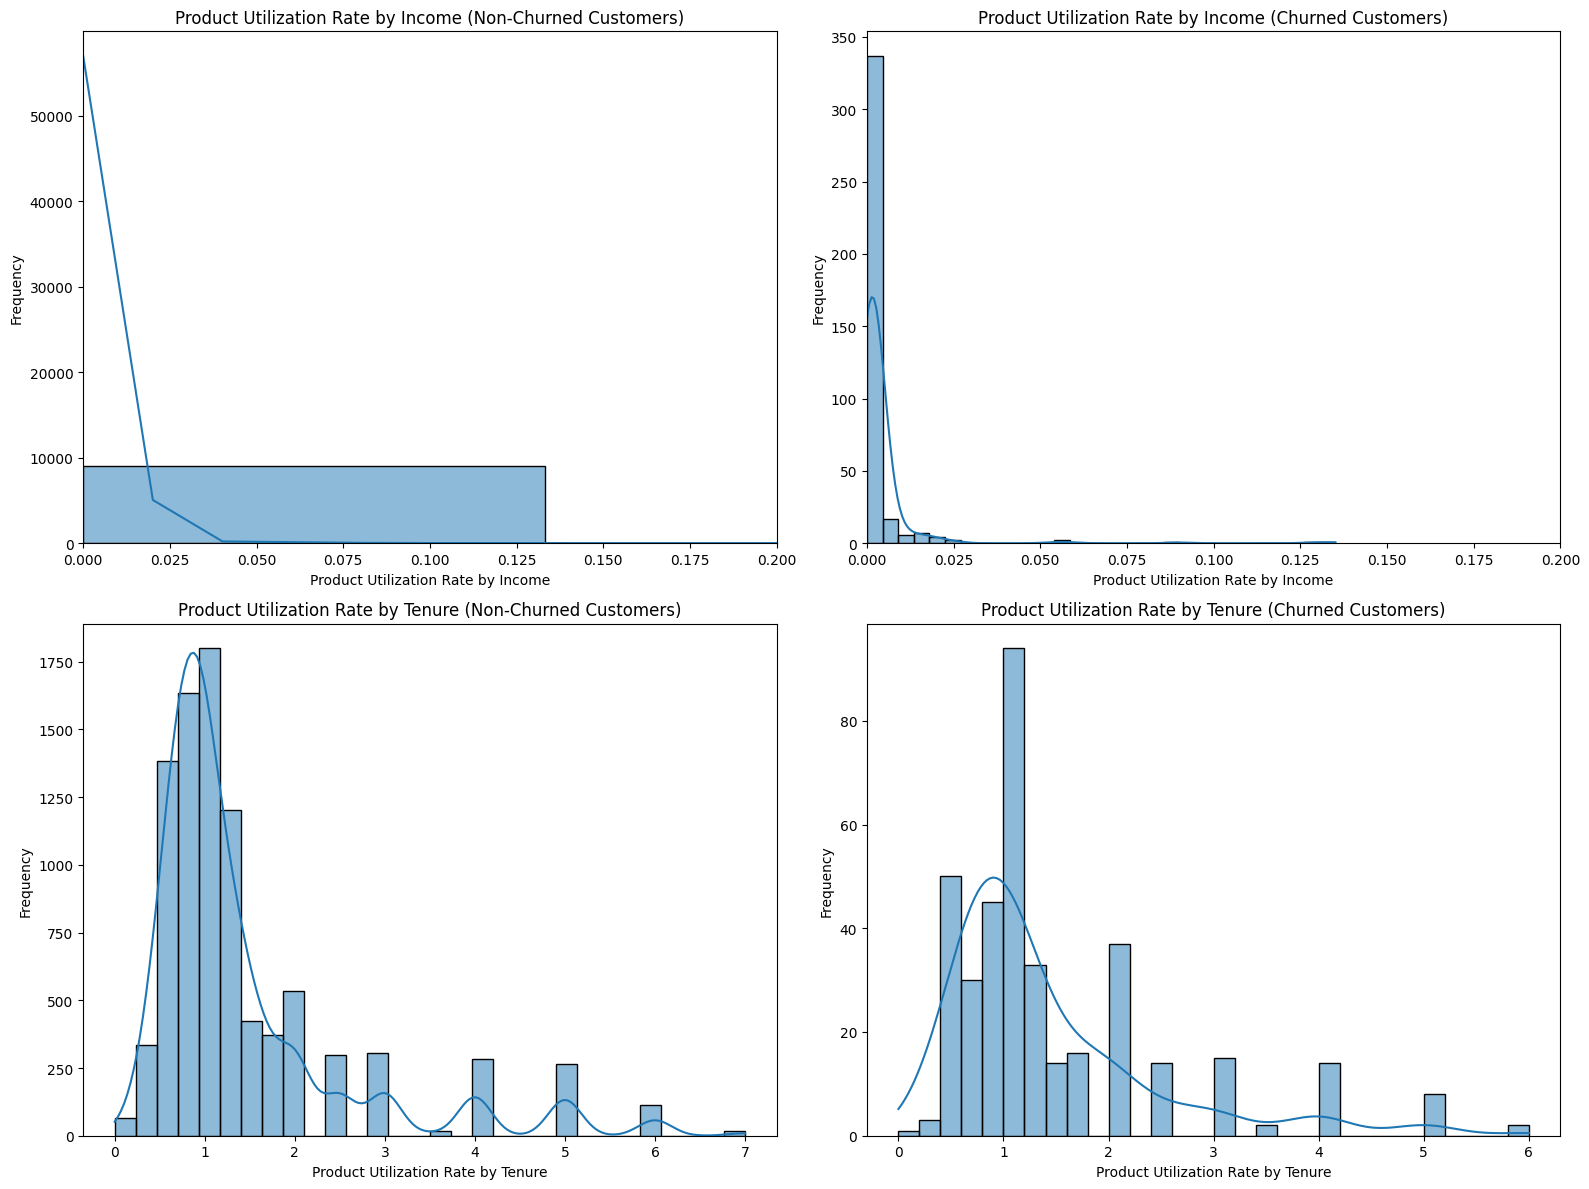

In [40]:

# Plot product_utilization_rate_by_income and product_utilization_rate_by_tenure side by side for churned and non-churned customers
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot product_utilization_rate_by_income for non-churned customers
sns.histplot(df[df['churn_status'] == 0]['product_utilization_rate_by_income'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Product Utilization Rate by Income (Non-Churned Customers)')
axes[0, 0].set_xlabel('Product Utilization Rate by Income')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_xlim([0, 0.2])

# Plot product_utilization_rate_by_income for churned customers
sns.histplot(df[df['churn_status'] == 1]['product_utilization_rate_by_income'], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Product Utilization Rate by Income (Churned Customers)')
axes[0, 1].set_xlabel('Product Utilization Rate by Income')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_xlim([0, 0.2])

# Plot product_utilization_rate_by_tenure for non-churned customers
sns.histplot(df[df['churn_status'] == 0]['product_utilization_rate_by_tenure'], bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Product Utilization Rate by Tenure (Non-Churned Customers)')
axes[1, 0].set_xlabel('Product Utilization Rate by Tenure')
axes[1, 0].set_ylabel('Frequency')

# Plot product_utilization_rate_by_tenure for churned customers
sns.histplot(df[df['churn_status'] == 1]['product_utilization_rate_by_tenure'], bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Product Utilization Rate by Tenure (Churned Customers)')
axes[1, 1].set_xlabel('Product Utilization Rate by Tenure')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

y = df["churn_status"]
X = df.drop(columns=['churn_status', 'job', 'marital', 'education', 'customer_segment', 'region', 'created_at', 'churn_id','churn_date'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 12345)


num_cols = X.columns[1:]

sc = StandardScaler()
X_train[num_cols] = sc.fit_transform(X_train[num_cols])
X_test[num_cols] = sc.transform (X_test[num_cols])

In [79]:
models = []
models.append(('LOGR',LogisticRegression()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('RF',RandomForestClassifier()))
models.append(('GBM',GradientBoostingClassifier()))
models.append(('XGBoost',XGBClassifier()))
models.append(('LightGBM',LGBMClassifier()))

df_result = pd.DataFrame(columns=["model","accuracy_score","0_precision","0_recall","1_precision","1_recall"])
index = 0
for name,model in models:
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test,y_pred)
    class_report = classification_report(y_test,y_pred,digits=2,output_dict=True)
    zero_report = class_report['0']
    one_report = class_report['1']
    df_result.loc[index, ['model', 'accuracy_score', '0_precision', '0_recall', '1_precision', '1_recall']] = [
    name, score, zero_report['precision'], zero_report['recall'], one_report['precision'], one_report['recall']]
    index += 1
df_result.sort_values("accuracy_score",ascending=False)

c:\Users\Abu Ubaidah\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Abu Ubaidah\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Abu Ubaidah\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics

[LightGBM] [Info] Number of positive: 308, number of negative: 7235
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 922
[LightGBM] [Info] Number of data points in the train set: 7543, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.040833 -> initscore=-3.156586
[LightGBM] [Info] Start training from score -3.156586


,model,accuracy_score,0_precision,0_recall,1_precision,1_recall
0,LOGR,0.97508,0.979404,0.995044,0.780488,0.457143
3,RF,0.97508,0.978885,0.995595,0.794872,0.442857
6,LightGBM,0.974549,0.978355,0.995595,0.789474,0.428571
5,XGBoost,0.973489,0.977814,0.995044,0.763158,0.414286
4,GBM,0.971368,0.977766,0.992841,0.690476,0.414286
1,KNN,0.962884,0.962884,1.0,0.0,0.0
2,CART,0.948038,0.975111,0.970815,0.320513,0.357143


In [80]:
logr_model = LogisticRegression(max_iter=1000)

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}

# Define the scoring metric
scorer = make_scorer(recall_score, average='macro')

# Perform GridSearchCV
grid_search = GridSearchCV(logr_model, param_grid, scoring=scorer, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters and best recall score
print("Best parameters found: ", grid_search.best_params_)
print("Best recall score: ", grid_search.best_score_)

# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_recall = recall_score(y_test, y_pred, average='macro')
print("Test set recall score: ", test_recall)


c:\Users\Abu Ubaidah\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Abu Ubaidah\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

Best parameters found:  {'C': 0.1, 'solver': 'newton-cg'}
Best recall score:  0.7293573165289917
Test set recall score:  0.7260934550031466


In [81]:
logr_model = LogisticRegression(C = 0.1, solver = 'liblinear')
logr_model.fit(X_train,y_train)
y_pred = logr_model.predict(X_test)

df_optimized = pd.DataFrame(columns=["model","accuracy_score","0_precision","0_recall","1_precision","1_recall"])

print(classification_report(y_test, y_pred, digits=2))
print("Accuracy score of tuned LogReg model: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1816
           1       0.78      0.46      0.58        70

    accuracy                           0.98      1886
   macro avg       0.88      0.73      0.78      1886
weighted avg       0.97      0.98      0.97      1886

Accuracy score of tuned LogReg model:  0.9750795334040296


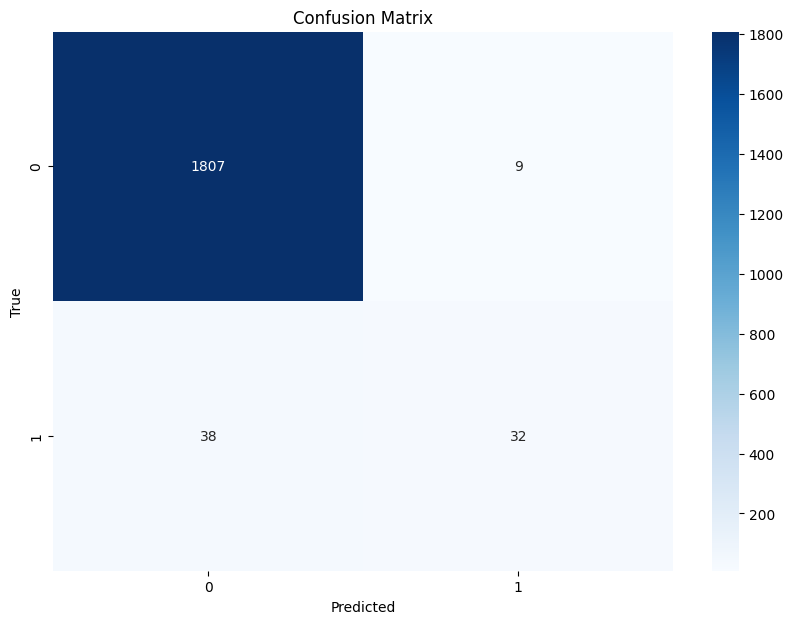

True Negatives:  1807
False Positives:  9
False Negatives:  38
True Positives:  32


In [82]:
cm= confusion_matrix(y_test, y_pred=y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

tn, fp, fn, tp = cm.ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

C:\Users\Abu Ubaidah\AppData\Local\Temp\ipykernel_6704\917045868.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


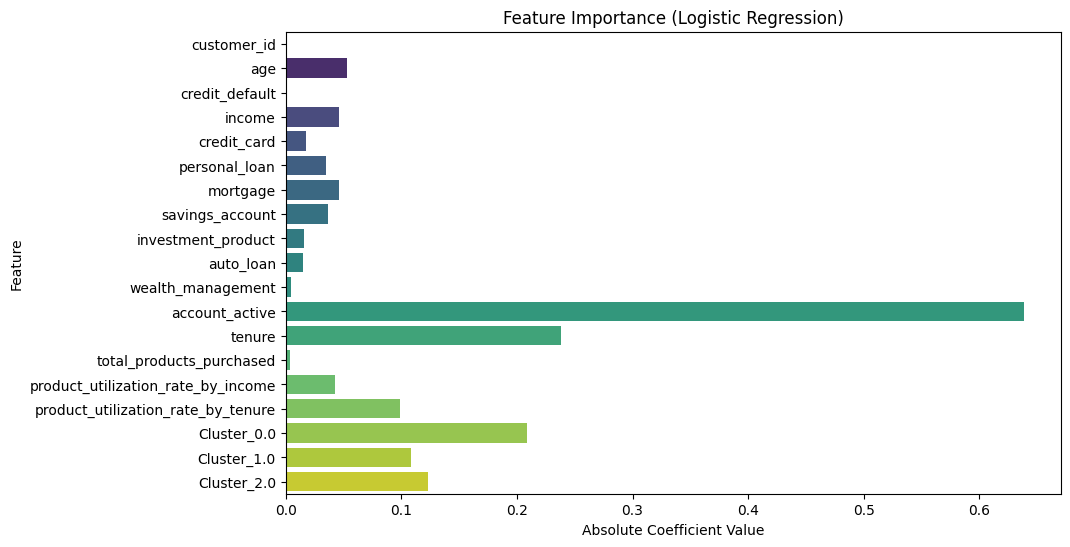

In [83]:
importance = np.abs(logr_model.coef_[0])
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": importance})

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")

plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.title("Feature Importance (Logistic Regression)")
plt.show()

In [104]:
X = pd.concat([X_train, X_test], ignore_index=True)
probs = logr_model.predict_proba(X)
X['churn_prob'] = probs[:, 1]
churn_prob_df = X[['customer_id', 'churn_prob']]
churn_prob_df.to_excel("../data/churn_data.xlsx", sheet_name="Churn Predictions", index=False)